## XML to YOLO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


### convert XML to YOLO text files

In [21]:
import os
import xml.etree.ElementTree as ET

# Input and output directories
input_dir = 'raw data/NewRawData/xml_labels'  #input directory of XML files
output_dir = 'raw data/NewRawData/yolo_labels'  #ouput dirctory of newly created yolo text files

# Function to convert bounding box coordinates to YOLO format
def convert_coordinates(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

# Function to convert class name to YOLO class index
def convert_class_name_to_index(class_name):
    if class_name == 'without_mask':
        return 0
    elif class_name == 'with_mask':
        return 1
    else:
        return None


# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate through each XML file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.xml'):
        # Parse XML file
        tree = ET.parse(os.path.join(input_dir, filename))
        root = tree.getroot()

        # Get image size
        size = (int(root.find('size').find('width').text), int(root.find('size').find('height').text))

        # Create YOLO format text file
        output_filename = os.path.splitext(filename)[0] + '.txt'
        with open(os.path.join(output_dir, output_filename), 'w') as f:
            # Iterate through each object
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                class_index = convert_class_name_to_index(class_name)
                if class_index is not None:
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)
                    # Convert bounding box coordinates to YOLO format
                    x, y, w, h = convert_coordinates(size, (xmin, ymin, xmax, ymax))
                    # Write to YOLO format text file
                    f.write(f"{class_index} {x} {y} {w} {h}\n")


## Confirm YOLO annotations

### verify the XML to YOLO TXT conversion by randomly visualizing the images with yolo text files

Error processing file: 0004_JPEG.rf.dae1fa66b853f5f69ac40a0a6a96503a.jpg. Error message: too many values to unpack (expected 5)
Error processing file: 0029_JPEG.rf.7f9e67c7c53bfe769309b3d3c16ff456.jpg. Error message: too many values to unpack (expected 5)
Error processing file: moderate_196_jpg.rf.7004e32c7c450f3262cbb6299b2492e6.jpg. Error message: too many values to unpack (expected 5)
Error processing file: damage_530_jpg.rf.30d155e35964f3f28a1f76db3d07b98a.jpg. Error message: too many values to unpack (expected 5)
Error processing file: damage_1927_jpg.rf.a0f94615e64cd711e7f92cec9fc9484a.jpg. Error message: too many values to unpack (expected 5)
Error processing file: minor_143_jpg.rf.f68c32b46e90541ff1d6b5de3d25c1c7.jpg. Error message: too many values to unpack (expected 5)
Error processing file: minor_188_jpg.rf.46240cbf9846e329953ef20bbb8ffe94.jpg. Error message: too many values to unpack (expected 5)
Error processing file: major_130_jpg.rf.36fe2d3382e2df1cb163bc91b87e5991.jpg. 

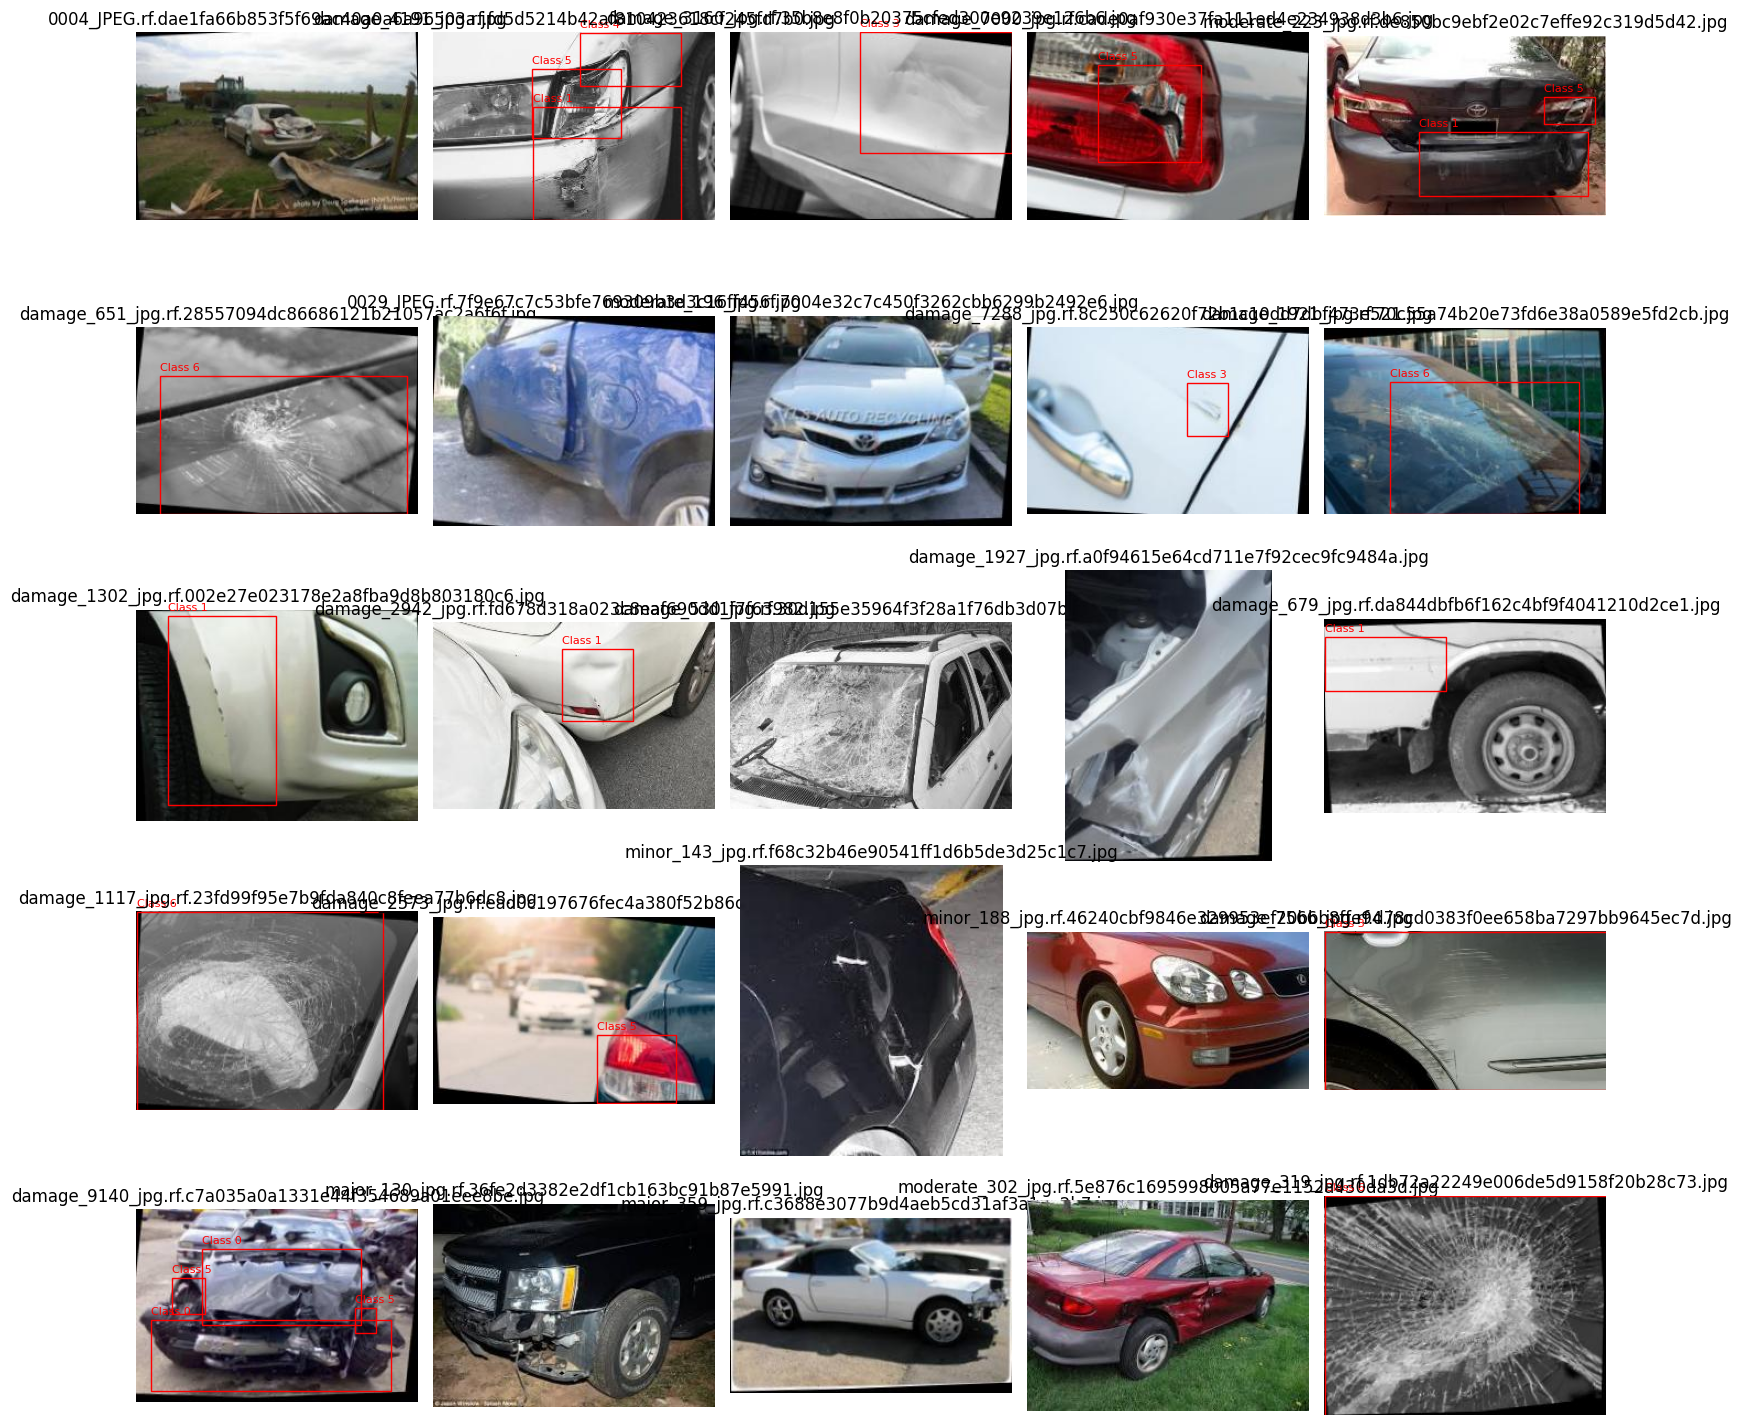

In [2]:
import os
import random
import shutil

# Directory paths
images_dir = "Car Damage Detection/train/images"
annotations_dir = "Car Damage Detection/train/labels"

# Function to convert YOLO format bounding box to integers
def convert_yolo_to_int(box, image_width, image_height):
    x_center, y_center, w, h = box
    x_center *= image_width
    y_center *= image_height
    w *= image_width
    h *= image_height
    x_min = int(x_center - (w / 2))
    y_min = int(y_center - (h / 2))
    x_max = int(x_center + (w / 2))
    y_max = int(y_center + (h / 2))
    return x_min, y_min, x_max, y_max

# Define function to display images with annotations in a grid
def display_images_with_annotations_grid(images_dir, annotations_dir, num_images=25, grid_shape=(5, 5)):
    # Get list of image files
    image_files = os.listdir(images_dir)
    # Randomly select num_images images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    # Create subplots
    fig, axes = plt.subplots(*grid_shape, figsize=(15, 15))
    # Flatten axes if grid_shape is not provided correctly
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    else:
        axes = axes.flatten()
    # Iterate through selected images
    for i, image_file in enumerate(selected_images):
        try:
            # Get corresponding annotation file
            annotation_file = os.path.join(annotations_dir, os.path.splitext(image_file)[0] + '.txt')
            # Read image
            image_path = os.path.join(images_dir, image_file)
            image = Image.open(image_path)
            image_width, image_height = image.size
            # Display the image
            axes[i].imshow(image)
            axes[i].axis('off')  # Disable axis
            axes[i].set_title(image_file)  # Set title as image filename
            # Check if annotation file exists
            if os.path.exists(annotation_file):
                # Read YOLO format text file
                with open(annotation_file, 'r') as f:
                    lines = f.readlines()
                # Iterate through each line in the YOLO format text file
                for line in lines:
                    class_index, x_center, y_center, w, h = map(float, line.split())
                    # Convert YOLO format bounding box to integers
                    x_min, y_min, x_max, y_max = convert_yolo_to_int((x_center, y_center, w, h), image_width, image_height)
                    # Calculate width and height of the bounding box
                    bbox_width = x_max - x_min
                    bbox_height = y_max - y_min
                    # Create a Rectangle patch
                    rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
                    # Add the patch to the Axes
                    axes[i].add_patch(rect)
                    # Add label name to the bounding box
                    class_name = 'Class ' + str(int(class_index))
                    axes[i].text(x_min, y_min - 5, class_name, color='r', fontsize=8)
        except Exception as e:
            print(f"Error processing file: {image_file}. Error message: {str(e)}")

    # Hide any empty subplots
    for j in range(len(selected_images), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()  # Adjust layout
    plt.show()

# Display 25 images with annotations in a grid
display_images_with_annotations_grid(images_dir, annotations_dir, num_images=25, grid_shape=(5, 5))



### Check for Class Imbalance

In [9]:
import os

# Directory containing YOLO format text files
yolo_txt_dir = 'Car Damage Detection/master/labels'

def count_class_frequency(yolo_txt_dir):
    class_frequency = {}
    # Iterate through each YOLO format text file in the directory
    for filename in os.listdir(yolo_txt_dir):
        if filename.endswith('.txt'):
            # Read the content of the text file
            with open(os.path.join(yolo_txt_dir, filename), 'r') as file:
                lines = file.readlines()
            # Iterate through each line in the text file
            for line in lines:
                class_index = int(line.split()[0])
                # Update the class frequency dictionary
                if class_index not in class_frequency:
                    class_frequency[class_index] = 1
                else:
                    class_frequency[class_index] += 1
    return class_frequency



# Count class frequency
class_frequency = count_class_frequency(yolo_txt_dir)

# Print class frequency
for class_index, frequency in class_frequency.items():
    print(f"Class {class_index}: {frequency} occurrences")


Class 3: 1242 occurrences
Class 6: 629 occurrences
Class 4: 1336 occurrences
Class 1: 2403 occurrences
Class 0: 466 occurrences
Class 5: 906 occurrences
Class 2: 218 occurrences


### divide data into train val and test for YOLOv8

In [24]:
import os
import shutil
import random


# Define paths
master_image_folder = "raw data/NewRawData/selected_images"  # folder containing all images
master_label_folder = "raw data/NewRawData/selected_labels"  # folder containing all labels
train_folder = "raw data/NewRawData/new_train"
test_folder = "raw data/NewRawData/new_test"
validation_folder = "raw data/NewRawData/new_valid"



def create_folders_if_not_exist(folder_paths):
    for folder_path in folder_paths:
        os.makedirs(folder_path, exist_ok=True)

def copy_images_and_labels(images_folder, labels_folder, image_list, destination_folder):
    for image_file in image_list:
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(destination_folder, 'images', image_file))
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(destination_folder, 'labels', label_file))

def split_dataset(master_image_folder, master_label_folder, train_folder, test_folder, validation_folder, split_ratio=(0.8, 0.1, 0.1)):
    # Create train, test, and validation folders if they don't exist
    create_folders_if_not_exist([train_folder, test_folder, validation_folder])

    # Create images and labels folders inside train, test, and validation folders
    create_folders_if_not_exist([os.path.join(train_folder, 'images'), os.path.join(train_folder, 'labels')])
    create_folders_if_not_exist([os.path.join(test_folder, 'images'), os.path.join(test_folder, 'labels')])
    create_folders_if_not_exist([os.path.join(validation_folder, 'images'), os.path.join(validation_folder, 'labels')])

    # Get list of image files in the master image folder
    image_files = os.listdir(master_image_folder)
    num_images = len(image_files)
    
    # Shuffle the list of image files
    random.shuffle(image_files)

    # Calculate number of images for train, test, and validation sets
    num_train = int(split_ratio[0] * num_images)
    num_test = int(split_ratio[1] * num_images)
    num_validation = num_images - num_train - num_test

    # Assign images to train, test, and validation sets
    train_images = image_files[:num_train]
    test_images = image_files[num_train:num_train+num_test]
    validation_images = image_files[num_train+num_test:]

    # Copy images and label files to corresponding folders
    copy_images_and_labels(master_image_folder, master_label_folder, train_images, train_folder)
    copy_images_and_labels(master_image_folder, master_label_folder, test_images, test_folder)
    copy_images_and_labels(master_image_folder, master_label_folder, validation_images, validation_folder)



# Split dataset
split_dataset(master_image_folder, master_label_folder, train_folder, test_folder, validation_folder)


### Randomly copy x number of samples from corresponding image-text pair from 2 image-label directory to target path

In [1]:
import os
import random
import shutil

def random_pick_images_and_annotations(image_dir, annotation_dir, num_samples):
    # Get list of all files in image directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    # Shuffle the list
    random.shuffle(image_files)
    # Select the first num_samples files
    selected_images = image_files[:num_samples]

    # Copy selected images to new directory
    selected_image_dir = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/new/selected_images"
    os.makedirs(selected_image_dir, exist_ok=True)
    for image_file in selected_images:
        shutil.copy(os.path.join(image_dir, image_file), selected_image_dir)

    # Corresponding annotations have the same name as selected images
    selected_annotations = [f.replace('.jpg', '.txt').replace('.png', '.txt') for f in selected_images]

    # Copy selected annotations to new directory
    selected_annotation_dir = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/new/selected_labels"
    os.makedirs(selected_annotation_dir, exist_ok=True)
    for annotation_file in selected_annotations:
        shutil.copy(os.path.join(annotation_dir, annotation_file), selected_annotation_dir)

# Set the directories containing images and annotations
image_directory = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/train/images"
annotation_directory = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/train/labels"

# Number of samples to select
num_samples = 2500

# Call the function
random_pick_images_and_annotations(image_directory, annotation_directory, num_samples)


### Rename files

In [7]:
import os

# Function to rename files in a directory
def rename_files(directory):
    # Get list of files in the directory
    files = os.listdir(directory)
    # Sort files to ensure consistent numbering
    files.sort()
    # Initialize counter
    counter = 1
    # Iterate through files
    for file_name in files:
        # Get file extension
        file_ext = os.path.splitext(file_name)[1]
        # Construct new file name with counter
        new_file_name = str(counter).zfill(4) + file_ext
        # Rename the file
        os.rename(os.path.join(directory, file_name), os.path.join(directory, new_file_name))
        # Increment counter
        counter += 1

# Directories
images_dir = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/new/selected_images"
labels_dir = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/new/selected_labels"

# Rename files in images directory
rename_files(images_dir)
# Rename files in labels directory
rename_files(labels_dir)


### find invalid text files in the labels folder

In [3]:
import os

# Function to check if a line adheres to the YOLO annotation format
def is_valid_yolo_format(line):
    # Split the line by space and check if there are exactly 5 elements
    elements = line.split()
    if len(elements) != 5:
        return False
    try:
        # Attempt to convert each element to float
        float_elements = [float(e) for e in elements]
        # Check if class_id is an integer
        if not float_elements[0].is_integer():
            return False
    except ValueError:
        return False
    return True

# Function to find files in the labels folder that do not adhere to YOLO annotation format
def find_invalid_files(folder_path):
    invalid_files = []
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r") as file:
                # Read each line and check if it adheres to YOLO annotation format
                for line_num, line in enumerate(file, start=1):
                    if not is_valid_yolo_format(line.strip()):
                        invalid_files.append(filename)
                        break  # No need to continue checking once an invalid line is found
    return invalid_files

# Replace 'labels' with the path to your labels folder
folder_path = 'Car Damage Detection/train/labels'
invalid_files = find_invalid_files(folder_path)

# Print the list of invalid files and the count
print("Number of files with invalid YOLO annotation format:", len(invalid_files))
print("Files with invalid YOLO annotation format:")
for filename in invalid_files:
    print(filename)


Number of files with invalid YOLO annotation format: 2994
Files with invalid YOLO annotation format:
0001_JPEG.rf.35b92ea47004142d14374a6dc3f0fac1.txt
0001_JPEG.rf.8cce9bb7a46ff7494b475d1ab652324a.txt
0001_JPEG.rf.9712435083d6ed5619e24e5d12bcdd39.txt
0001_JPEG.rf.ad0647e07930a79458e1f80695f8e498.txt
0001_JPEG.rf.bbab7a9463114788f10db6e2f5c8d740.txt
0001_JPEG.rf.e8076299da681eff80d176c8b40afd5e.txt
0002_JPEG.rf.21a9363147422aa787a92f0ce24b0c5e.txt
0002_JPEG.rf.2bdf8eb0ca85fdc40c4ce29501c1394c.txt
0002_JPEG.rf.5aeea6a6f2a49e582fe10b51c5a323a5.txt
0002_JPEG.rf.60502e8ba6db092b573d99b5dfc2be6a.txt
0002_JPEG.rf.c3fad40bcc56081a12cce4916075e064.txt
0002_JPEG.rf.d4240fd548e009db2e9efe8b090c3b4f.txt
0003_JPEG.rf.346c734eb0cdb58dc48820ac1baaf8b5.txt
0003_JPEG.rf.3bda2e8e50c234ac629b92e6c15577a1.txt
0003_JPEG.rf.4d8d118f13aa74da9543a1827ece1432.txt
0003_JPEG.rf.54f270e64d4c0d01654401964582d7c2.txt
0003_JPEG.rf.699babb888c2cb34191b6541b58ac5f8.txt
0003_JPEG.rf.a406e427922bac5c7a62fb4a3a5ebce2.txt

### Delete abnormal image-text pair files

In [8]:
import os

def delete_image_and_labels(image_dir, labels_dir, files_to_delete):
    deleted_count = 0
    # Delete image files
    for file in files_to_delete:
        image_path = os.path.join(image_dir, os.path.splitext(file)[0] + ".jpg")  # Assuming images have .jpg extension
        label_path = os.path.join(labels_dir, file)
        if os.path.exists(image_path):
            os.remove(image_path)
            deleted_count += 1
            print(f"Deleted {image_path}")
        if os.path.exists(label_path):
            os.remove(label_path)
            deleted_count += 1
            print(f"Deleted {label_path}")
    return deleted_count

# Example usage:
image_directory = 'Car Damage Detection/val/images'
labels_directory = 'Car Damage Detection/val/labels'
files_to_delete = invalid_files  # List of text files to delete along with corresponding images

deleted_count = delete_image_and_labels(image_directory, labels_directory, files_to_delete)
print(f"Total files deleted: {deleted_count}")


Total files deleted: 0


### change class ids to any number

In [16]:
import os

def change_class_id_to_zero(labels_folder):
    # Iterate over each file in the labels folder
    for filename in os.listdir(labels_folder):
        if filename.endswith(".txt"):
            file_path = os.path.join(labels_folder, filename)
            # Read the contents of the file
            with open(file_path, "r") as file:
                lines = file.readlines()
            # Modify each line to change class_id to 0
            modified_lines = []
            for line in lines:
                elements = line.split()
                if len(elements) == 5:
                    # Change the class_id to 0------------------------
                    elements[0] = '0'
                    # Join the elements back into a line
                    modified_line = ' '.join(elements) + '\n'
                    modified_lines.append(modified_line)
            # Write the modified lines back to the file
            with open(file_path, "w") as file:
                file.writelines(modified_lines)
            print(f"Class IDs changed to 0 in file: {filename}")

# Example usage:
labels_folder = "C:/Users/arnav/Downloads/face detection.v9i.yolov8/new/selected_labels"
change_class_id_to_zero(labels_folder)


Class IDs changed to 0 in file: 0001.txt
Class IDs changed to 0 in file: 0002.txt
Class IDs changed to 0 in file: 0003.txt
Class IDs changed to 0 in file: 0004.txt
Class IDs changed to 0 in file: 0005.txt
Class IDs changed to 0 in file: 0006.txt
Class IDs changed to 0 in file: 0007.txt
Class IDs changed to 0 in file: 0011.txt
Class IDs changed to 0 in file: 0012.txt
Class IDs changed to 0 in file: 0013.txt
Class IDs changed to 0 in file: 0017.txt
Class IDs changed to 0 in file: 0018.txt
Class IDs changed to 0 in file: 0019.txt
Class IDs changed to 0 in file: 0020.txt
Class IDs changed to 0 in file: 0021.txt
Class IDs changed to 0 in file: 0022.txt
Class IDs changed to 0 in file: 0023.txt
Class IDs changed to 0 in file: 0024.txt
Class IDs changed to 0 in file: 0032.txt
Class IDs changed to 0 in file: 0033.txt
Class IDs changed to 0 in file: 0034.txt
Class IDs changed to 0 in file: 0035.txt
Class IDs changed to 0 in file: 0036.txt
Class IDs changed to 0 in file: 0037.txt
Class IDs change

Divide the Data into train test split

In [ ]:
import os
import shutil
import random

# Define the paths
master_folder = "car damage severity classification\\master"
train_folder = "car damage severity classification\\data\\train"
test_folder = "car damage severity classification\\data\\test"
val_folder = "car damage severity classification\\data\\valid"

# Create train, test, and val directories if they don't exist
for folder in [train_folder, test_folder, val_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Get the class names from subfolder names in the master directory
classes = [d for d in os.listdir(master_folder) if os.path.isdir(os.path.join(master_folder, d))]

# Define the split ratios
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create subfolders for each class inside train, test, and val folders
for folder in [train_folder, test_folder, val_folder]:
    for class_name in classes:
        class_folder = os.path.join(folder, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

# Iterate through each class folder
for class_name in classes:
    class_folder = os.path.join(master_folder, class_name)
    images = os.listdir(class_folder)
    num_images = len(images)

    # Shuffle the images
    random.shuffle(images)

    # Calculate split indices
    train_split = int(train_ratio * num_images)
    test_split = int((train_ratio + test_ratio) * num_images)

    # Split the images
    train_images = images[:train_split]
    test_images = images[train_split:test_split]
    val_images = images[test_split:]

    # Move images to respective folders
    for image in train_images:
        src = os.path.join(class_folder, image)
        dst = os.path.join(train_folder, class_name, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dst = os.path.join(test_folder, class_name, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(class_folder, image)
        dst = os.path.join(val_folder, class_name, image)
        shutil.copy(src, dst)

print("Data split completed successfully.")
